In [2]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from utils.helpers import * 
from models_config.model_config_GSP_vanilla_exploration import *
from models_config.model_config_GSP import *


import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {
    'text.usetex' : True,
    'font.size' : 11,
    'font.family' :'lmodern'
}
plt.rcParams.update(params)


/var/folders/1j/5s36wz6s0jlb1k64vsq1k2zh0000gn/T/ipykernel_26428/735282662.py:21: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


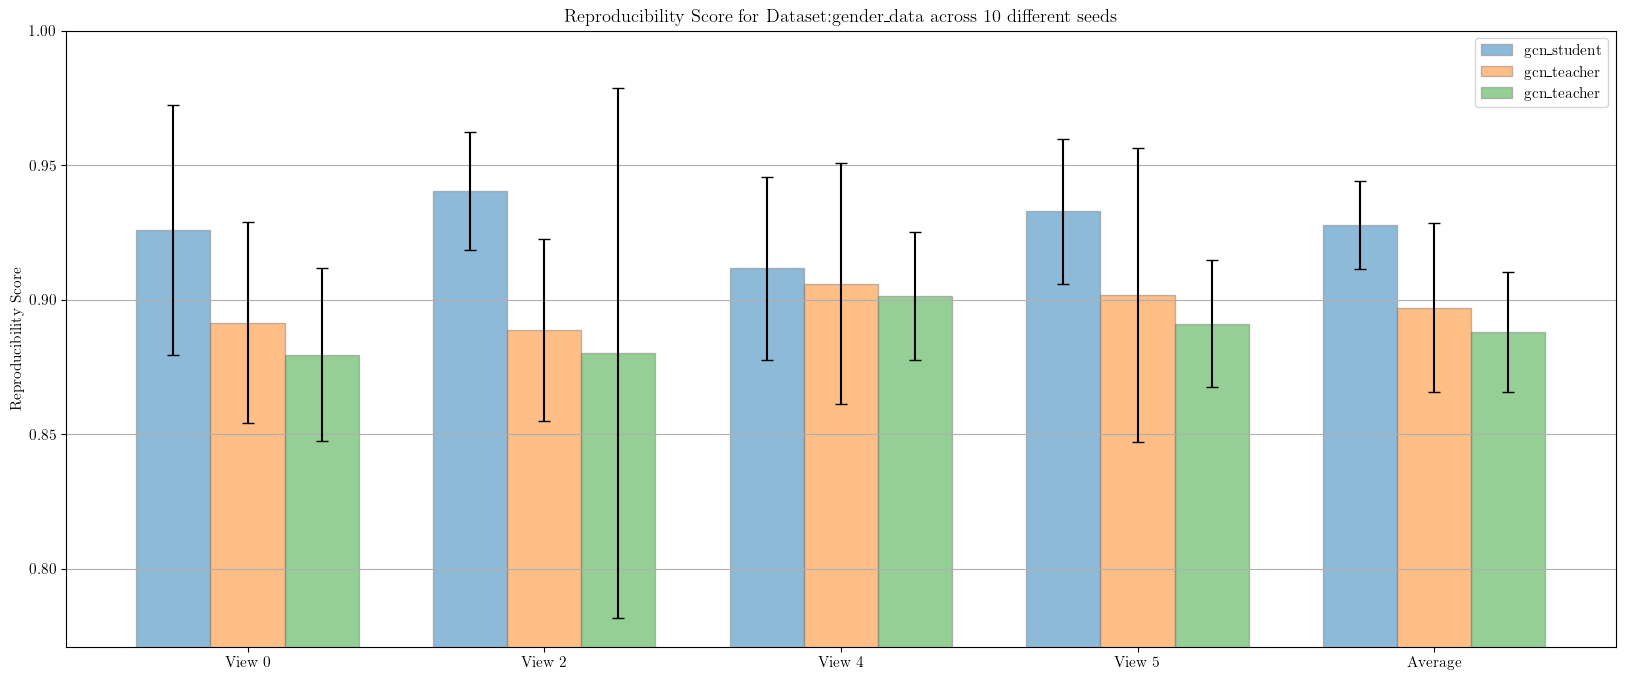

<Figure size 2000x800 with 0 Axes>

In [3]:
dataset="gender_data"
views=[0, 2, 4, 5]
models=["gcn_student", "gcn", "gcn"]
model_args = [gcn_student_args, gcn_args, gcn_3_args]
CV=["3Fold", "5Fold", "10Fold"]
runs=[i for i in range(10)]
save_fig=False

plot_bar_chart_reproducibility_mulitple_runs(dataset, views, models, CV, runs, students=[-1,-1,-1], model_args=model_args, save_fig=False)

## Accuracy

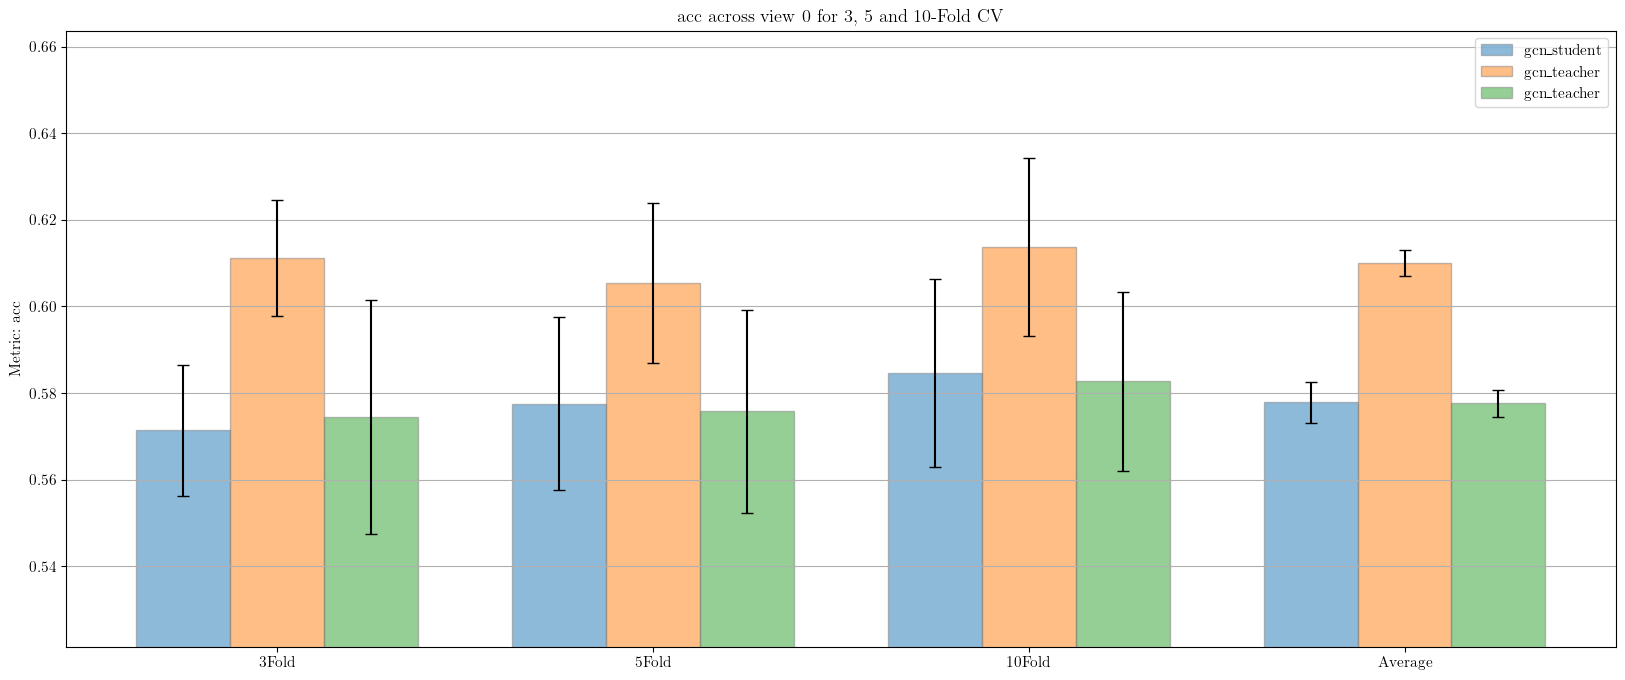

<Figure size 2000x800 with 0 Axes>

In [4]:
plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=0, 
                                    models=["gcn_student", "gcn", "gcn"],
                                    CV=["3Fold", "5Fold", "10Fold"], 
                                    runs=[i for i in range(10)], 
                                    metric="acc", 
                                    dataset_split="val", 
                                    analysis_type="model_assessment", 
                                    model_args=[gcn_student_args, gcn_args, gcn_3_args], 
                                    save_fig=False)


## Model Size 

In [3]:
model_1_dir = '/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/gender_data/gcn/model_assessment/gcn_student/models/gcn_student_MainModel_3Fold_gender_data_gcn_student_run_0_fixed_init_CV_0_view_0.pt'
model_2_dir = '/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/gender_data/gcn/model_assessment/gcn/models/gcn_MainModel_3Fold_gender_data_gcn_run_0_fixed_init_CV_0_view_0.pt'
model_3_dir = '/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/gender_data/gcn/model_assessment/gcn/models/gcn_MainModel_3Fold_gender_data_gcn_run_0_fixed_init_layers_3_CV_0_view_0.pt'

model_layer_1 = torch.load(model_1_dir)
model_layer_2 = torch.load(model_2_dir)
model_layer_3 = torch.load(model_3_dir)

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model_layer_1), count_parameters(model_layer_2), count_parameters(model_layer_3)

(108, 2470, 6630)

In [7]:
def percentage_decrease(original_value, new_value):
    decrease = original_value - new_value
    percentage = (decrease / original_value) * 100
    return percentage

percentage_decrease(2470, 108)

95.62753036437248

## Inference time 

In [8]:
import time
from torch.autograd import Variable

def inference_time(model):
    
    model.eval()
    
    G_list = load_data("gender_data", 0, NormalizeInputGraphs=False)

    folds = stratify_splits(G_list, 3)
        
    [random.shuffle(folds[i]) for i in range(len(folds))]
    train_set, validation_set, test_set = datasets_splits(folds, model_args, 0)
    train_dataset, val_dataset, threshold_value = model_assessment_split(train_set, validation_set, test_set, gcn_student_args)

    for batch_idx, data in enumerate(train_dataset):

        adj = Variable(data['adj'].float(), requires_grad=False).to(device)
        adj = torch.squeeze(adj)

        features = np.identity(adj.shape[0])
        features = Variable(torch.from_numpy(features).float(), requires_grad=False).to("cpu")
        if gcn_student_args["threshold"] in ["median", "mean"]:
            adj = torch.where(adj > threshold_value, torch.tensor([1.0]).to("cpu"), torch.tensor([0.0]).to("cpu"))

        begin_time = time.time()

        model(features, adj)

        return time.time() - begin_time


In [9]:
inference_time(model_layer_1), inference_time(model_layer_2), inference_time(model_layer_3)

Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232


(0.012597084045410156, 0.0018568038940429688, 0.0005660057067871094)

# MOTIVATION FOR REPRODUCIBLE KDG

In [10]:
def reproducibility_mulitple_runs_values(dataset, views, models, CV, runs, students=[-1,-1,-1], model_args=model_args, save_fig=False):  
    
    mean_all_runs = []
    
    for run in runs:
        view_data_mean, _ = view_reproducibility_analysis(dataset, models, CV, views, run, students, model_args)
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0)
    mean_all_runs = np.mean(mean_all_runs, axis=0)

    return mean_all_runs, mean_all_std

In [11]:
mean_all_runs, mean_all_std = reproducibility_mulitple_runs_values(dataset, views, models, CV, runs, students=[-1,-1,-1], model_args=model_args, save_fig=False)

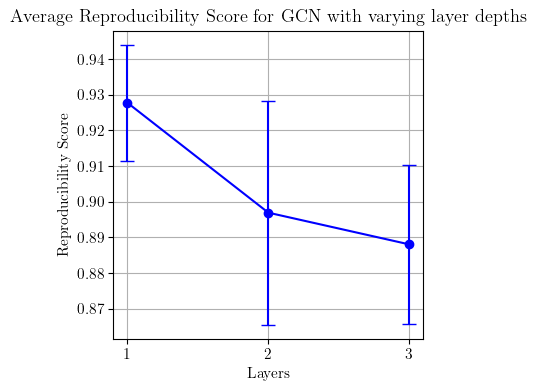

In [45]:
plt.rcParams["figure.figsize"] = (4,4)
layers = [1,2,3]
# Sample data
x = layers
y = mean_all_runs.T[-1]
std = mean_all_std.T[-1]

# Plotting
plt.plot(x, y, color='b')
plt.errorbar(x, y, yerr=std, fmt='o', capsize=5, color='b')
plt.xticks(x, x)

# Customize the plot
plt.xlabel('Layers')
plt.ylabel('Reproducibility Score')
plt.title('Average Reproducibility Score for GCN with varying layer depths')

# Display the plot
plt.grid()
plt.show()

In [17]:
inference_time_1 = [inference_time(model_layer_1) for i in range(10)]
inference_time_2 = [inference_time(model_layer_2) for i in range(10)]
inference_time_3 = [inference_time(model_layer_3) for i in range(10)]

Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232


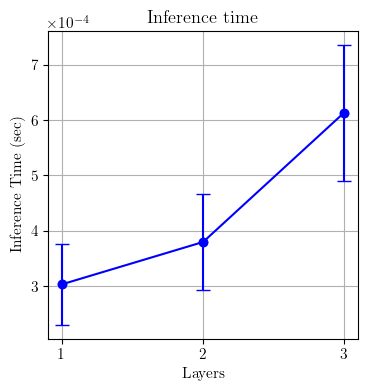

In [46]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (4,4)

# Sample data
x = layers
y = [np.mean(inference_time_1),np.mean(inference_time_2),np.mean(inference_time_3)]
# Plotting
plt.plot(x, y, color='b')
plt.errorbar(x, y, yerr=[np.std(inference_time_1),np.std(inference_time_2),np.std(inference_time_3)], fmt='o', capsize=5, label='Standard Deviation', color='b')
plt.scatter(x, y)
plt.xticks(x, x)

# Customize the plot
plt.xlabel('Layers')
plt.ylabel('Inference Time (sec)')
plt.title('Inference time')
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#plt.legend()

# Display the plot
plt.show()